This notebook prepares the ebutterfly data, not co-located with ebird), data from USA (starting year 2010), we  start with clustering the observations, creates polygons to extract the satellite images from planetary computer, filters images that are smaller than 128x128, creates the targets by aggregating the checklists, saves final csv for the hotspots

In [3]:
import pandas as pd 
import geopandas as gpd
import os
import numpy as np
import glob
from pathlib import Path    
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon, Point
from math import cos, radians

In [30]:
root_dir = "/home/hagerradi/projects/Ecosystem_embeddings/ebutterfly/Darwin/0177350-230224095556074"
dataset_tag = "SatButterfly_v1"

In [ ]:
# filter locations outside the continental US
def filter_locations(df): # (slow) takes around 30 mins
    gdf = gpd.read_file(os.path.join(root_dir, "cb_2018_us_nation_5m/cb_2018_us_nation_5m.shp"))
    indices = []
    for i, row in tqdm(df.iterrows()):
        if not gdf.geometry[0].contains(Point(row["decimalLongitude"], row["decimalLatitude"])):
            indices += [i]

    df_clean = df.drop(indices)
    return df_clean

def get_main_df(df_file_name):
    buttefly_data_US = pd.read_csv(os.path.join(root_dir, df_file_name))

    # exclude observations in states
    states_to_exclude = ['Alaska', 'Hawaii']
    buttefly_data_US = buttefly_data_US[~buttefly_data_US['stateProvince'].isin(states_to_exclude)]
    
    # filter out based on USA geography
    buttefly_data_US = filter_locations(buttefly_data_US)

    return buttefly_data_US

butterfly_data_US = get_main_df("occ_usa.csv")
print(butterfly_data_US)
butterfly_data_US.to_csv(os.path.join(root_dir, "occ_usa_geo_filtered.csv"))

- occ_usa.csv is extracted from ebutterfly raw observations (ebutterfly/Darwin/0177350-230224095556074/occurrence.txt, where country code in the US and starting the year 2010
- If the folder cb_2018_us_nation_5m does not exist, you can download from: https://www.census.gov/geographies/mapping-files/2018/geo/carto-boundary-file.html 

# Clustering ebutterfly data

In [ ]:
def cluster_ebutterfly_data(df):
    RADIUS_EARTH = 6356.7523 

    coordinates = df[['decimalLatitude', 'decimalLongitude']].values

    eps = 1/RADIUS_EARTH # Maximum distance between points to be considered part of the same cluster
    min_samples = 2  # Minimum number of points in a cluster (including the core point)

    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

    cluster_labels = db.labels_

    # Number of clusters in labels, ignoring noise (-1 is noise)
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    num_noise = len(set(cluster_labels)) - num_clusters
    print("Number of clusters:", num_clusters)
    print("Number of noise:", num_noise)

    clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters)])

    # print(clusters)
    def get_centermost_point(cluster):
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)

    centermost_points = clusters.map(get_centermost_point)
    center_lats, center_lons = zip(*centermost_points)

    # save final dataframe
    df["cluster_label"] = cluster_labels

    df = df[df["cluster_label"] != -1]
    print(df)
    cluster_labels = cluster_labels[np.where(cluster_labels != -1)]

    df["center_lat"] = [center_lats[cl] for cl in cluster_labels]
    df["center_lon"] = [center_lons[cl] for cl in cluster_labels]
    df["hotspot_id"] = ["L" + str(cl) for cl in cluster_labels]

    df.reset_index(drop=True)

    return df

butterfly_data_US = pd.read_csv(os.path.join(root_dir, "occ_usa_geo_filtered.csv"))
butterfly_data_US_clustered = cluster_ebutterfly_data(df=butterfly_data_US)
butterfly_data_US_clustered.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_clustered.csv"))

# Generate satellite images

### 1. Create polygons for the lats, lons

In [ ]:
def generate_buffer_meter(data, radius, geometry='geometry', crs='epsg:4326', projected_crs='epsg:3857'): 
    """ Generates a buffer around the geometries in a geopandas DataFrame. 
    Parameters: 
        data (GeoDataFrame or DataFrame): The geopandas dataframe or a pandas dataframe that contains geometry data. 
        radius (float): The radius of the buffer in meters. 
        geometry (str, optional): The column in the dataframe that contains the geometry information. Defaults to 'geometry'. 
        crs (str, optional): The Coordinate Reference System of the input geometries. Defaults to 'epsg:4326'. 
        projected_crs (str, optional): The projected CRS to use for buffering. Defaults to 'epsg:3857'. 
    Returns: 
        GeoDataFrame: A new geopandas dataframe with the buffer applied to the geometry. 
    """ 
    data = gpd.GeoDataFrame(data) 
    data = data.to_crs(projected_crs)
    data[geometry] = data[geometry].buffer(radius, cap_style=3)
    data = data.to_crs(crs)
    return data

def generate_geometry(df):
    df = df.drop_duplicates().reset_index()

    geometry = [Point(xy) for xy in zip(df['center_lon'], df['center_lat'])]
    crs = {'init':'epsg:4326'}

    geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

    data_df = generate_buffer_meter(geo_df, 2500)
    return data_df


center_data_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_clustered.csv"), usecols=["hotspot_id", "center_lon", "center_lat"])
data_df = generate_geometry(center_data_df)

print(data_df.shape)

print(data_df)

data_df.to_csv(os.path.join(root_dir, dataset_tag, "ebutterfly_center_polygons.csv"))

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


def plot_coordinates(df):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    colors = {'train': 'b', 'test':'y', 'valid':'m'}

    ax.scatter(x=df['center_lon'], y=df['center_lat'], color='red')

    plt.show()

    ax.set_title('Coordinates on USA Map')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()

plot_coordinates(butterfly_data_US_clustered)

### 2. use the polygons file to extract satellite images from planetary compute, using the script (data_processing/ebutterfly_data_preparation/download_rasters_from_planetary_computer.py)

### 3. Filter satellite images and save final

(404, 406, 3)
(369, 370, 3)
(438, 440, 3)
(372, 373, 3)
(387, 389, 3)
(349, 350, 3)
(400, 402, 3)
(381, 382, 3)


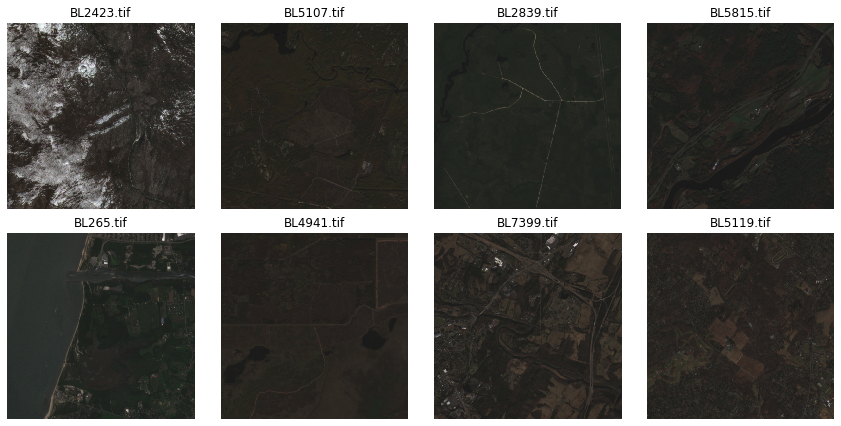

7608
['L2422', 'L982', 'L4109', 'L4483', 'L919', 'L228', 'L4978', 'L5229', 'L7180', 'L5527', 'L288', 'L5412', 'L5464', 'L6147', 'L6084', 'L1389', 'L410', 'L4376', 'L792', 'L3435', 'L6062', 'L2924', 'L1530', 'L4289', 'L1189', 'L528', 'L844', 'L378', 'L2136', 'L5965', 'L1964', 'L2243', 'L1937', 'L6182', 'L6843', 'L63', 'L6341', 'L333', 'L7092', 'L5290', 'L3697', 'L3275', 'L4166', 'L3081', 'L1370', 'L5189', 'L7074', 'L5469', 'L4869', 'L2946', 'L2887', 'L2969', 'L387', 'L6657', 'L36', 'L5607', 'L7366', 'L1303', 'L3554', 'L3304', 'L2142', 'L735', 'L2809', 'L1350', 'L6306', 'L5825', 'L5516', 'L1844', 'L7605', 'L1471', 'L2693', 'L4837', 'L6519', 'L1939', 'L7043', 'L2754', 'L4925', 'L7481', 'L6913', 'L4435', 'L2403', 'L5856', 'L6753', 'L2452', 'L1223', 'L4737', 'L1521', 'L5312', 'L5348', 'L1142', 'L1022', 'L2148', 'L6315', 'L269', 'L3704', 'L3769', 'L3048', 'L6546', 'L2207', 'L3623', 'L1614', 'L7500', 'L110', 'L2669', 'L1295', 'L5157', 'L5241', 'L5208', 'L4227', 'L318', 'L190', 'L2657', 'L4497

In [19]:
import glob
import random
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import shutil
from pathlib import Path    
import os

def filter_satellite_images(dst, image_folder="raw_images"):
    # exclude images less than 128x128
    if not os.path.exists(dst):
        os.makedirs(dst)
    
    # src
    file_list = glob.glob(os.path.join(root_dir, dataset_tag, image_folder,  "*"))
    for i, file_path in enumerate(file_list):
        with rio.open(file_path) as f:
            r = f.read(3)
            g = f.read(2)
            b = f.read(1)
        composite = np.stack((r, g, b), axis=-1)
        if composite.shape[0] >= 128 and composite.shape[1] >= 128:
            shutil.copy(file_path, dst)

def get_final_hotspots(dst):
    final_hotspots = []
    file_list = glob.glob(os.path.join(dst, "*"))
    for i, file_path in enumerate(file_list):
        final_hotspots.append(str(Path(file_path).name.split(".")[0][1:]))
    
    print(len(final_hotspots))
    
    return final_hotspots

def explore_satellite_images(image_folder):
    file_list = glob.glob(os.path.join(root_dir, dataset_tag, image_folder, "*"))

    # Select 8 random files from the list
    random_files = random.sample(file_list, 8)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i, file_path in enumerate(random_files):
        with rio.open(file_path) as f:
            r = f.read(3)
            g = f.read(2)
            b = f.read(1)

        # Create a composite image from RGB channels
        composite = np.stack((r, g, b), axis=-1)
        print(composite.shape)

        # Clip and normalize the values
        normalized_composite = np.clip((composite / 10000), 0, 1)

        # Get the title from the file name
        title = file_path.split("/")[-1]

        # Plot the image in the corresponding subplot
        ax = axes[i // 4, i % 4]
        ax.imshow(normalized_composite)
        ax.set_title(title)
        ax.axis('off')
    # Adjust spacing and display the plot
    plt.tight_layout()
    plt.show()

explore_satellite_images(image_folder="images")
# exclude images of smaller sizes
dst = os.path.join(root_dir, dataset_tag, "images")
# filter_satellite_images(dst=dst, image_folder="raw_images")
final_hotspots = get_final_hotspots(dst)
print(final_hotspots)

# butterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots.csv"))

# butterfly_df = butterfly_df[butterfly_df['hotspot_id'].isin(final_hotspots)]

# butterfly_df.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_final.csv"))

# Create hotspots csv

In [20]:
# group data of each cluster
def group_clusters(butterfly_df):
    grouped_butterfly_data = butterfly_df.groupby(['hotspot_id'])
        
    group_sizes = grouped_butterfly_data.size()
    
    print(group_sizes)
    
    return grouped_butterfly_data

butterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_clustered.csv"))
# exclude the clusters that have no satellite images
butterfly_df = butterfly_df[butterfly_df['hotspot_id'].isin(final_hotspots)]

grouped_butterfly_data = group_clusters(butterfly_df)

/home/hagerradi/anaconda3/envs/main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (66,67,209) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


        Unnamed: 0  Unnamed: 0.1      gbifID  abstract  accessRights  \
0                0             0  3922908706       NaN           NaN   
1                1             1  3922904702       NaN           NaN   
2                2             2  3922908713       NaN           NaN   
3                3             3  3922904710       NaN           NaN   
4                4             4  3922908720       NaN           NaN   
...            ...           ...         ...       ...           ...   
220740      225854        225854  3397369406       NaN           NaN   
220741      225855        225855  3397369407       NaN           NaN   
220742      225856        225856  3397369418       NaN           NaN   
220743      225857        225857  3427427343       NaN           NaN   
220744      225858        225858  3427427344       NaN           NaN   

        accrualMethod  accrualPeriodicity  accrualPolicy  alternative  \
0                 NaN                 NaN            NaN      

In [32]:
# save species list of all unique species
def save_species_list(df):
    species_list = df["species"].unique().tolist()
    species_df = df['species'].value_counts()
    
    species_df = species_df.reset_index()
    species_df.columns = ['species', 'frequency']
    
    species_df.to_csv(os.path.join(root_dir, dataset_tag, 'species_list.csv'), index=False)
    
    return species_df

butterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_clustered.csv"))
# exclude the clusters that have no satellite images
butterfly_df = butterfly_df[butterfly_df['hotspot_id'].isin(final_hotspots)]

species_list = save_species_list(butterfly_df)
# print(species_list)

                  species  frequency
0        Danaus plexippus       8477
1            Pieris rapae       8463
2        Phyciodes tharos       7357
3         Papilio glaucus       5396
4          Junonia coenia       4982
..                    ...        ...
610         Eurema salome          1
611     Oenomaus ortygnus          1
612       Papilio garamas          1
613  Junonia nigrosuffusa          1
614      Quadrus lugubris          1

[615 rows x 2 columns]


In [25]:
# an intermediate step done once: 
# saving the list of species (common and union) between the hotspots here and ebird hotspots
species_list = pd.read_csv(os.path.join(root_dir, dataset_tag, 'species_list.csv'))
species_list_2 = pd.read_csv(os.path.join(root_dir, "SatButterfly_v2", 'species_list.csv'))

print(species_list)
print(species_list_2)
species_list = species_list[species_list["frequency"] >= 100]
species_list_2 = species_list_2[species_list_2["frequency"] >= 100]

print(species_list)
print(species_list_2)

# species_list.to_csv(os.path.join(root_dir, dataset_tag, 'species_list_>=100.csv'), index=False)
# species_list_2.to_csv(os.path.join(root_dir, "SatButterfly_v2", 'species_list_>=100.csv'), index=False)

final_species_list_intersect = np.intersect1d(species_list['species'].values.tolist(), species_list_2['species'].values.tolist())
final_species_list_union = np.union1d(species_list['species'].values.tolist(), species_list_2['species'].values.tolist())

print(final_species_list_intersect)

# with open(os.path.join(root_dir, "intersection_species_list_>=100.txt"), 'w') as outfile:
#     outfile.write('\n'.join(str(species_name) for species_name in final_species_list_intersect))

# with open(os.path.join(root_dir, "union_species_list_>=100.txt"), 'w') as outfile:
#     outfile.write('\n'.join(str(species_name) for species_name in final_species_list_union))

# save new species lists with the intersection of species only
new_species_list_2 = species_list_2[species_list_2['species'].isin(final_species_list_intersect)]
# new_species_list_2.to_csv(os.path.join(root_dir, "SatButterfly_v2", 'species_list_updated.csv'), index=False)

new_species_list = species_list[species_list['species'].isin(final_species_list_intersect)]
print(new_species_list)
print(new_species_list_2)
# new_species_list.to_csv(os.path.join(root_dir, dataset_tag, 'species_list_updated.csv'), index=False)


# species_list = new_species_list['species'].values.tolist()
# print(len(species_list))

               species  frequency
0     Danaus plexippus       8477
1         Pieris rapae       8463
2     Phyciodes tharos       7357
3      Papilio glaucus       5396
4       Junonia coenia       4982
..                 ...        ...
610   Heliopetes alana          1
611      Eurema salome          1
612  Clossiana astarte          1
613   Autochton cincta          1
614   Piruna haferniki          1

[615 rows x 2 columns]
                 species  frequency
0           Pieris rapae       6818
1       Danaus plexippus       6721
2       Phyciodes tharos       5295
3        Papilio glaucus       3830
4       Colias philodice       3598
..                   ...        ...
597  Pholisora mejicanus          1
598       Mimoides phaon          1
599        Mastor oslari          1
600       Boloria frigga          1
601  Hypolimnas misippus          1

[602 rows x 2 columns]
                species  frequency
0      Danaus plexippus       8477
1          Pieris rapae       8463
2      

In [28]:
# create targets by aggregating checklists
import json
from tqdm import tqdm

def compute_target_files(grouped_butterfly_data, output_folder, species_list):
    problamtic = []
    for group_name, group_data in tqdm(grouped_butterfly_data):
#         print(group_data['decimalLatitude'], group_data['decimalLongitude'])
        target = {}
        checklist_ = np.zeros(len(species_list))
        # dropping species that appear more than once in the same checklist
        new_df = group_data[['eventID', 'species']]
        new_df = new_df.drop_duplicates(['eventID', 'species'])

        for sp in new_df['species']:
            if sp in species_list:
                checklist_[species_list.index(sp)] += 1
        target['num_complete_checklists'] = len(group_data['eventID'].unique())
        checklist_ = checklist_ / target['num_complete_checklists']
        if np.max(checklist_) > 1 :
            problamtic.append(group_name)

        target['probs'] = checklist_.tolist()
        target['hotspot_id'] = group_name
    
        with open(os.path.join(output_folder, "B"+str(group_name) + ".json"), 'w') as fp:
            json.dump(target, fp)
    return problamtic

dst = os.path.join(root_dir, dataset_tag, "butterfly_targets_v1.2")
if not os.path.exists(dst):
    os.makedirs(dst)

print(final_species_list_intersect)
# problems = compute_target_files(grouped_butterfly_data, dst, final_species_list_intersect.tolist())
# print(len(problems))

['Abaeis nicippe' 'Achalarus lyciades' 'Achlyodes thraso'
 'Aglais milberti' 'Anaea aidea' 'Anaea andria' 'Anartia jatrophae'
 'Ancyloxypha numitor' 'Anthanassa texana' 'Anthocharis midea'
 'Anthocharis sara' 'Ascia monuste' 'Asterocampa celtis'
 'Asterocampa clyton' 'Asterocampa leilia' 'Atalopedes campestris'
 'Atlides halesus' 'Atrytone delaware' 'Battus philenor' 'Boloria selene'
 'Brephidium exilis' 'Calephelis nemesis' 'Calephelis perditalis'
 'Callicista columella' 'Calpodes ethlius' 'Calycopis cecrops'
 'Calycopis isobeon' 'Celastrina ladon' 'Celastrina lucia'
 'Cercyonis pegala' 'Chioides catillus' 'Chiomara asychis'
 'Chlosyne lacinia' 'Chlosyne nycteis' 'Clossiana toddi'
 'Coenonympha tullia' 'Colias eurytheme' 'Colias philodice'
 'Copaeodes aurantiaca' 'Copaeodes minima' 'Cyaniris neglecta'
 'Cymaenes odilia' 'Danaus eresimus' 'Danaus gilippus' 'Danaus plexippus'
 'Dione vanillae' 'Dryas iulia' 'Dymasia dymas' 'Echinargus isola'
 'Elkalyce comyntas' 'Epargyreus clarus' 'Ere

In [ ]:
# save final csv
# columns: hotspot_name, lon, lat, number_of_observations, number_of_unique_checklists, number_of_unique_species, env variables
def save_final_csv(grouped_butterfly_data, output_filename='butterfly_hotspots.csv'):
    hotspot_ids = []
    lats, lons = [], []
    number_of_butterfly_obs = []
    number_of_unique_checklists = []
    number_of_different_species = []
    states = []

    for group_name, group_data in tqdm(grouped_butterfly_data):
        if group_name in final_hotspots:
            hotspot_ids.append(str(group_name))
            lats.append(group_data['center_lat'].iloc[0])
            lons.append(group_data['center_lon'].iloc[0])
            states.append(group_data['stateProvince'].iloc[0])
            number_of_butterfly_obs.append(len(group_data['occurrenceID']))
            number_of_unique_checklists.append(len(group_data['eventID'].unique()))
            number_of_different_species.append(len(group_data['species'].unique()))

    final_data_frame = pd.DataFrame({'hotspot_id': hotspot_ids,
                                     'lat': lats,
                                     'lon': lons,
                                     'stateProvince': states,
                                     'ebutterfly_occurances': number_of_butterfly_obs,
                                     'num_checklists': number_of_unique_checklists,
                                     'num_species': number_of_different_species})

    print(final_data_frame)

    final_data_frame.to_csv(os.path.join(root_dir, dataset_tag, output_filename) , index=False)
    

save_final_csv(grouped_butterfly_data, 'butterfly_hotspots.csv')

## Extract environmental rasters

#### use the polygons file to extract environmental rasters, using the script (data_processing/environmental/get_env_var.py)
#### preferably on the cluster for the use of (geolifeclef-2022/rasters) data, using 'butterfly_hotspots.csv'

In [ ]:
dst = os.path.join(root_dir, dataset_tag, "environmental_data")
if not os.path.exists(dst):
    os.makedirs(dst)

### split data using DBSCAN (script: data_processing/utils/make_splits_by_distance.py), using the final csv (butterfly_hotspots.csv)

In [ ]:
def save_different_split_files(butterfly_data_with_split):
    grouped_butterfly_data = butterfly_data_with_split.groupby(['split'], as_index=False)

    for group_name, group_data in tqdm(grouped_butterfly_data):
        print(group_name)
        print(group_data["ebutterfly_occurances"].max())
        group_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_" + str(group_name) + ".csv"))
        
butterfly_data_with_split = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_with_splits.csv"))

save_different_split_files(butterfly_data_with_split)

### Visualize map after splitting

In [ ]:
# plot final splits
import os
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

import numpy as np
import pandas as pd
import json

import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point


def plot_final_splits(df):
    geoDatav = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)   

    ig, ax = plt.subplots(figsize =(15,10))
    #train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
    geoDatav[~geoDatav["STATE"].isin(["02", "15"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
    gdf[gdf["split"]=="train"].plot(ax=ax,marker='o', color='mediumslateblue', markersize=1, label = "train")
    gdf[gdf["split"]=="val"].plot(ax=ax, marker='o', color='lightseagreen', markersize=1, label = "val")
    gdf[gdf["split"]=="test"].plot(ax=ax, marker='o', color='lightsalmon', markersize=1, label = "test")

    plt.legend(fontsize=16, markerscale=5,loc='lower right',  bbox_to_anchor=(0.92, 0.25))
    plt.title("butterfly Hotspots")
    plt.show()

    
path = os.path.join(root_dir, dataset_tag, "butterfly_hotspots_with_splits.csv")
plot_final_splits(df=pd.read_csv(path))

In [ ]:
path = os.path.join(root_dir, "ebutterfly_data_v2", "butterfly_hotspots_with_splits.csv")
plot_final_splits(pd.read_csv(path))

Final files saved:
[('valid', 1147), ('test', 1145), ('train', 5316)]
- butterfly_hotspots.csv
- butterfly_hotspots_train.csv
- butterfly_hotspots_valid.csv
- butterfly_hotspots_test.csv
- species_list.csv
- butterfly_targets/
- environmental_data/
- images
- images_visual